In [1]:
# Cell 1: Environment Setup and Dependencies
import os
import sys
import platform
import random
from datetime import datetime
from pathlib import Path
import json
import yaml
import shutil

# Data analysis
import numpy as np
import pandas as pd
from PIL import Image, ExifTags
import cv2

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress tracking
from tqdm.notebook import tqdm

# Print Python and environment information
print(f"Python version: {platform.python_version()}")
print(f"Platform: {platform.platform()}")

# Check for CUDA
try:
    import torch
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA version: {torch.version.cuda}")
        print(f"GPU device: {torch.cuda.get_device_name(0)}")
        print(f"Number of GPUs: {torch.cuda.device_count()}")
    else:
        print("CUDA is not available - training will use CPU")
except ImportError:
    print("PyTorch is not installed - you'll need to install it with pip install torch torchvision")

# Check for other required libraries
required_packages = ['numpy', 'matplotlib', 'pandas', 'opencv-python', 'ultralytics']
for package in required_packages:
    try:
        if package == 'opencv-python':
            import cv2
            print(f"✅ {package} is installed (version: {cv2.__version__})")
        else:
            module = __import__(package.replace('-', '_'))
            print(f"✅ {package} is installed (version: {module.__version__})")
    except ImportError:
        print(f"❌ {package} is NOT installed - use pip install {package}")
    except AttributeError:
        print(f"✅ {package} is installed (version unknown)")

# Manually set the project root path to ensure accuracy
project_root = "/home/peter/Desktop/TU PHD/WildlifeDetectionSystem"
print(f"\nProject root path: {project_root}")

# Output the current working directory for reference
print(f"Current working directory: {os.getcwd()}")

# Define expected data paths and include alternate paths
data_paths = {
    'raw_images': os.path.join(project_root, 'data', 'raw_images'),
    'export_yolo_alt': os.path.join(project_root, 'data', 'export', 'yolo_export'),
    'models': os.path.join(project_root, 'models', 'trained'),
    'notebooks': os.path.join(project_root, 'notebooks')
}

# Check if directories exist and list sample files if they do
for name, path in data_paths.items():
    if os.path.exists(path):
        print(f"✅ {name} directory exists: {path}")
        try:
            files = os.listdir(path)
            if files:
                print(f"   Sample files: {files[:3]}")
            else:
                print(f"   Directory is empty")
        except Exception as e:
            print(f"   Error listing directory: {e}")
    else:
        print(f"❌ {name} directory does not exist: {path}")

# Check if we need to create any directories
missing_dirs = [path for name, path in data_paths.items() if not os.path.exists(path) and 'alt' not in name]
if missing_dirs:
    print("\nWould you like to create the missing directories? (y/n)")
    # Uncomment the line below to auto-create directories if needed
    # for path in missing_dirs:
    #     os.makedirs(path, exist_ok=True)
    #     print(f"Created directory: {path}")

print("\nEnvironment setup check complete!")

Python version: 3.12.3
Platform: Linux-6.8.0-58-generic-x86_64-with-glibc2.39
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
GPU device: NVIDIA GeForce RTX 4050 Laptop GPU
Number of GPUs: 1
✅ numpy is installed (version: 2.1.1)
✅ matplotlib is installed (version: 3.10.1)
✅ pandas is installed (version: 2.2.3)
✅ opencv-python is installed (version: 4.11.0)
✅ ultralytics is installed (version: 8.3.106)

Project root path: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem
Current working directory: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem/notebooks/training/Planned_Notebooks_v2
✅ raw_images directory exists: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem/data/raw_images
   Sample files: ['test_01']
❌ export_yolo_alt directory does not exist: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem/data/export/yolo_export
✅ models directory exists: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem/models/trained
   Sample files: ['wildlife_detector_improved'

In [2]:
# Cell 2: Configuration and Path Setup
# Define configurable paths with support for dynamic dataset selection

# Function to safely create directory if it doesn't exist
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")
    return directory

# Base project directory - use the exact same path as in your notebook
PROJECT_DIR = "/home/peter/Desktop/TU PHD/WildlifeDetectionSystem"
print(f"Project root: {PROJECT_DIR}")

# Dataset selection - using test_01 to match your existing notebook
DATASET_NAME = "test_01"  # This matches your existing notebook's path

# Define paths using the exact same structure as your notebook
data_dir = "/home/peter/Desktop/TU PHD/WildlifeDetectionSystem/data"
yolo_dataset_path = os.path.join(data_dir, "export/yolo_default_20250429_085945")
model_save_dir = "/home/peter/Desktop/TU PHD/WildlifeDetectionSystem/models/trained"
reports_dir = "/home/peter/Desktop/TU PHD/WildlifeDetectionSystem/reports"

# Define additional paths
paths = {
    "raw_data": os.path.join(PROJECT_DIR, "data", "raw_images", DATASET_NAME),
    "processed_data": os.path.join(PROJECT_DIR, "data", "processed", DATASET_NAME),
    "export_dir": os.path.join(PROJECT_DIR, "data", "export"),
    "models_dir": model_save_dir,  # Use the same path as your notebook
    "reports_dir": reports_dir     # Use the same path as your notebook
}

# Add timestamp for exports
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
paths["yolo_export"] = os.path.join(paths["export_dir"], f"yolo_export_{DATASET_NAME}_{timestamp}")
paths["yolo_hierarchical_export"] = os.path.join(paths["export_dir"], f"yolo_hierarchical_{DATASET_NAME}_{timestamp}")

# Verify paths
for name, path in paths.items():
    if os.path.exists(path):
        print(f"✅ {name} directory exists: {path}")
    else:
        print(f"❌ {name} directory does not exist: {path}")

# Also check the YOLO dataset path
print(f"\nYOLO dataset: {yolo_dataset_path}")
if os.path.exists(yolo_dataset_path):
    print(f"✅ YOLO dataset exists")
else:
    print(f"❌ YOLO dataset does not exist")

# Save configuration for use in other notebooks
config = {
    "project_dir": PROJECT_DIR,
    "dataset_name": DATASET_NAME,
    "timestamp": timestamp,
    "paths": paths,
    "yolo_dataset_path": yolo_dataset_path
}

config_dir = ensure_dir(os.path.join(PROJECT_DIR, "config"))
config_path = os.path.join(config_dir, f"data_config_{timestamp}.json")

with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)

print(f"\nConfiguration saved to: {config_path}")

Project root: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem
✅ raw_data directory exists: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem/data/raw_images/test_01
❌ processed_data directory does not exist: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem/data/processed/test_01
✅ export_dir directory exists: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem/data/export
✅ models_dir directory exists: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem/models/trained
✅ reports_dir directory exists: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem/reports
❌ yolo_export directory does not exist: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem/data/export/yolo_export_test_01_20250510_0038
❌ yolo_hierarchical_export directory does not exist: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem/data/export/yolo_hierarchical_test_01_20250510_0038

YOLO dataset: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem/data/export/yolo_default_20250429_085945
✅ YOLO dataset exists

Configura

Analyzing images in: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem/data/raw_images/test_01

Found 1882 total images across 1 directories

Top directories by image count:


,Directory,Image Count
0,root,1882


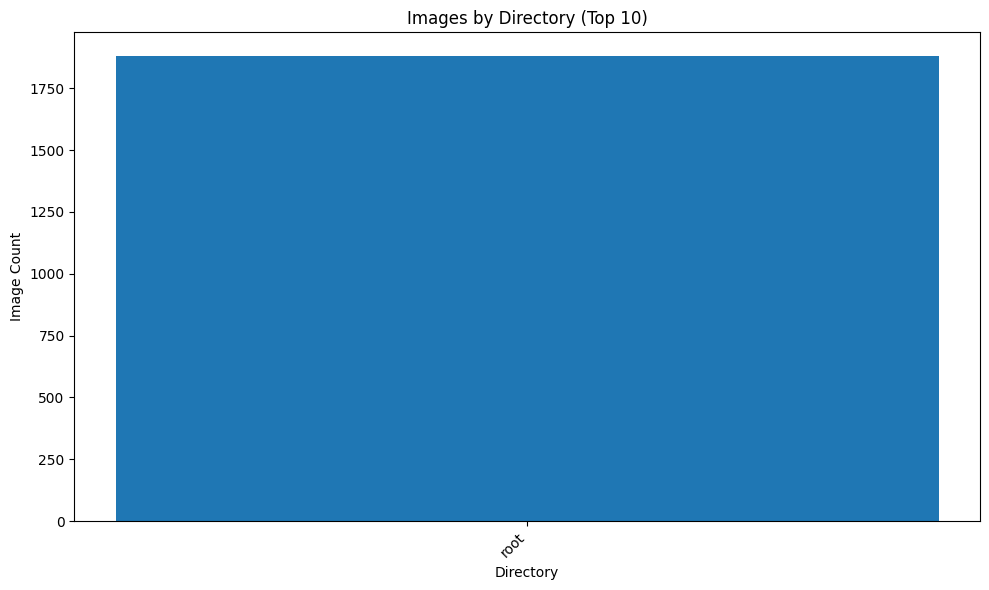


Analyzing metadata from 20 random images...

Image dimension statistics:
Width range: 3264 to 5632 pixels (avg: 3382.4)
Height range: 2448 to 4224 pixels (avg: 2536.8)


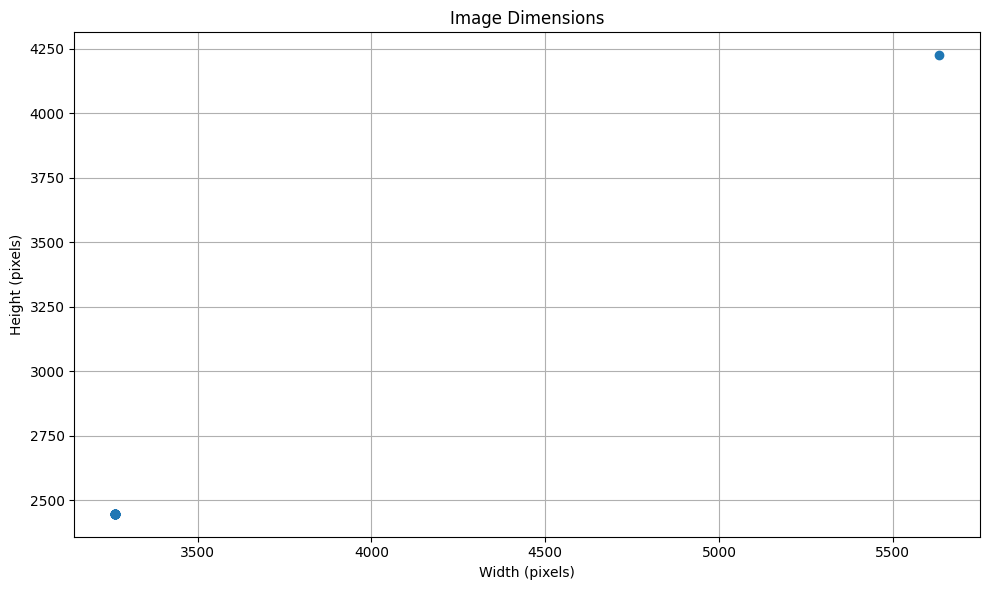

In [3]:
# Cell 3: Data Exploration - Image Analysis
# Analyze image distributions, formats, and metadata

def count_images_by_directory(base_dir):
    """Count images in each subdirectory of base_dir"""
    image_counts = {}
    total_images = 0
    
    if not os.path.exists(base_dir):
        print(f"❌ Directory does not exist: {base_dir}")
        return {}, 0
    
    for root, dirs, files in os.walk(base_dir):
        # Get relative path for display
        rel_path = os.path.relpath(root, base_dir)
        if rel_path == '.':
            rel_path = 'root'
            
        # Count image files
        image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'))]
        if image_files:
            image_counts[rel_path] = len(image_files)
            total_images += len(image_files)
    
    return image_counts, total_images

# Count images by directory - using the path from your notebook
raw_images_dir = paths['raw_data']  # This is /home/peter/Desktop/TU PHD/WildlifeDetectionSystem/data/raw_images/test_01
print(f"Analyzing images in: {raw_images_dir}")

if os.path.exists(raw_images_dir):
    image_counts, total_images = count_images_by_directory(raw_images_dir)
    
    # Display results
    print(f"\nFound {total_images} total images across {len(image_counts)} directories")
    
    # Create DataFrame for better display
    if image_counts:
        counts_df = pd.DataFrame(list(image_counts.items()), columns=['Directory', 'Image Count'])
        counts_df = counts_df.sort_values('Image Count', ascending=False).reset_index(drop=True)
        
        # Display top directories by image count
        print("\nTop directories by image count:")
        display(counts_df.head(10))
        
        # Visualize distribution if there are images
        if total_images > 0:
            plt.figure(figsize=(10, 6))
            plt.bar(counts_df['Directory'].head(10), counts_df['Image Count'].head(10))
            plt.title('Images by Directory (Top 10)')
            plt.xlabel('Directory')
            plt.ylabel('Image Count')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
    else:
        print("No image directories found.")
else:
    print(f"❌ Raw data directory not found: {raw_images_dir}")
    print("Please check the path and make sure the directory exists.")

# Extract metadata from sample images
def extract_image_metadata(image_path):
    """Extract metadata from an image file"""
    try:
        img = Image.open(image_path)
        metadata = {
            "path": image_path,
            "filename": os.path.basename(image_path),
            "size": img.size,
            "format": img.format,
            "mode": img.mode
        }
        
        # Extract EXIF data if available
        if hasattr(img, '_getexif') and img._getexif():
            exif = {
                ExifTags.TAGS.get(k, k): v
                for k, v in img._getexif().items()
                if not isinstance(v, bytes)  # Skip binary data
            }
            metadata["exif"] = exif
            
            # Extract common EXIF fields
            if "DateTime" in exif:
                metadata["datetime"] = exif["DateTime"]
            if "Make" in exif:
                metadata["camera_make"] = exif["Make"]
            if "Model" in exif:
                metadata["camera_model"] = exif["Model"]
        
        return metadata
    except Exception as e:
        return {"error": str(e), "path": image_path}

# Sample and analyze random images if we found any
if 'total_images' in locals() and total_images > 0:
    # Collect all image paths
    all_images = []
    for root, _, files in os.walk(raw_images_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
                all_images.append(os.path.join(root, file))
    
    # Sample images for metadata analysis
    sample_size = min(20, len(all_images))
    if sample_size > 0:
        print(f"\nAnalyzing metadata from {sample_size} random images...")
        sample_images = random.sample(all_images, sample_size)
        
        # Extract metadata
        metadata_samples = [extract_image_metadata(img) for img in sample_images]
        
        # Analyze image dimensions
        widths = [m["size"][0] for m in metadata_samples if "size" in m]
        heights = [m["size"][1] for m in metadata_samples if "size" in m]
        
        if widths and heights:
            print("\nImage dimension statistics:")
            print(f"Width range: {min(widths)} to {max(widths)} pixels (avg: {sum(widths)/len(widths):.1f})")
            print(f"Height range: {min(heights)} to {max(heights)} pixels (avg: {sum(heights)/len(heights):.1f})")
            
            # Visualize dimensions
            plt.figure(figsize=(10, 6))
            plt.scatter(widths, heights)
            plt.title('Image Dimensions')
            plt.xlabel('Width (pixels)')
            plt.ylabel('Height (pixels)')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    else:
        print("No images found for metadata analysis.")
else:
    print("No images found for metadata analysis.")

In [4]:
# Cell 4: YOLO Dataset Analysis
# Analyze existing YOLO dataset structure and annotations

# Using the exact path from your notebook
data_dir = "/home/peter/Desktop/TU PHD/WildlifeDetectionSystem/data"
yolo_dataset_path = os.path.join(data_dir, "export/yolo_default_20250429_085945")
print(f"Analyzing YOLO dataset: {yolo_dataset_path}")

if os.path.exists(yolo_dataset_path):
    # Check YOLO dataset structure
    print("\nYOLO Dataset Structure:")
    print(f"Classes file exists: {os.path.exists(os.path.join(yolo_dataset_path, 'classes.txt'))}")
    print(f"Data config exists: {os.path.exists(os.path.join(yolo_dataset_path, 'data.yaml'))}")
    print(f"Train images folder exists: {os.path.exists(os.path.join(yolo_dataset_path, 'images/train'))}")
    print(f"Train labels folder exists: {os.path.exists(os.path.join(yolo_dataset_path, 'labels/train'))}")
    print(f"Val images folder exists: {os.path.exists(os.path.join(yolo_dataset_path, 'images/val'))}")
    print(f"Val labels folder exists: {os.path.exists(os.path.join(yolo_dataset_path, 'labels/val'))}")
    
    # Read class names - only if classes.txt exists
    classes_path = os.path.join(yolo_dataset_path, 'classes.txt')
    if os.path.exists(classes_path):
        with open(classes_path, 'r') as f:
            class_names = [line.strip() for line in f.readlines()]
        print(f"\nClasses ({len(class_names)}): {class_names}")
    else:
        print("\nClasses file not found. Cannot analyze class distribution.")
        class_names = []
    
    # Define taxonomic groups exactly as in your notebook
    taxonomic_groups = {
        'Deer': [0, 1, 2, 3],  # Red Deer, Male Roe Deer, Female Roe Deer, Fallow Deer
        'Carnivores': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],  # Fox, Wolf, Jackal, etc.
        'Small_Mammals': [17, 18, 19, 20, 21],  # Rabbit, Hare, Squirrel, etc.
        'Birds': [23, 24, 25, 29],  # Blackbird, Nightingale, Pheasant, woodpecker
        'Other': [4, 5, 22, 26, 27, 28]  # Wild Boar, Chamois, Turtle, Human, Background, Dog
    }
    
    # Only print the hierarchical groups if we have class names
    if class_names:
        print("\nHierarchical Classification Groups:")
        for group_name, class_ids in taxonomic_groups.items():
            valid_class_ids = [idx for idx in class_ids if idx < len(class_names)]
            group_species = [class_names[idx] for idx in valid_class_ids]
            print(f"  {group_name}: {', '.join(group_species)}")
    
    # Count annotations per class
    train_labels_folder = os.path.join(yolo_dataset_path, 'labels/train')
    val_labels_folder = os.path.join(yolo_dataset_path, 'labels/val')
    
    # Initialize counters
    class_counts = {i: {'train': 0, 'val': 0} for i in range(len(class_names))} if class_names else {}
    total_annotations = {'train': 0, 'val': 0}
    
    # Get lists of label files
    train_label_files = os.listdir(train_labels_folder) if os.path.exists(train_labels_folder) else []
    val_label_files = os.listdir(val_labels_folder) if os.path.exists(val_labels_folder) else []
    
    print(f"\nTraining annotation files: {len(train_label_files)}")
    print(f"Validation annotation files: {len(val_label_files)}")
    
    # Only process if we have class names and label files
    if class_names and (train_label_files or val_label_files):
        # Process training files
        for label_file in train_label_files:
            label_path = os.path.join(train_labels_folder, label_file)
            try:
                with open(label_path, 'r') as f:
                    for line in f.readlines():
                        parts = line.strip().split()
                        if len(parts) >= 5:  # Valid label format
                            class_id = int(parts[0])
                            if class_id < len(class_names):
                                class_counts[class_id]['train'] += 1
                                total_annotations['train'] += 1
            except Exception as e:
                print(f"Error reading {label_file}: {e}")
        
        # Process validation files
        for label_file in val_label_files:
            label_path = os.path.join(val_labels_folder, label_file)
            try:
                with open(label_path, 'r') as f:
                    for line in f.readlines():
                        parts = line.strip().split()
                        if len(parts) >= 5:  # Valid label format
                            class_id = int(parts[0])
                            if class_id < len(class_names):
                                class_counts[class_id]['val'] += 1
                                total_annotations['val'] += 1
            except Exception as e:
                print(f"Error reading {label_file}: {e}")
        
        # Calculate taxonomic group counts
        group_counts = {group: {'train': 0, 'val': 0} for group in taxonomic_groups}
        for group_name, class_ids in taxonomic_groups.items():
            for class_id in class_ids:
                if class_id < len(class_names):
                    group_counts[group_name]['train'] += class_counts[class_id]['train']
                    group_counts[group_name]['val'] += class_counts[class_id]['val']
        
        # Display class distribution
        print("\nAnnotation distribution by class:")
        class_data = []
        for class_id in range(len(class_names)):
            train_count = class_counts[class_id]['train']
            val_count = class_counts[class_id]['val']
            total_count = train_count + val_count
            
            if total_count > 0:
                train_percent = (train_count / total_count) * 100 if total_count > 0 else 0
                val_percent = (val_count / total_count) * 100 if total_count > 0 else 0
                
                print(f"  {class_names[class_id]}: Train={train_count}, Val={val_count}, Total={total_count} ({train_percent:.1f}% / {val_percent:.1f}%)")
                
                class_data.append({
                    'Class': class_names[class_id],
                    'Train': train_count,
                    'Val': val_count,
                    'Total': total_count
                })
        
        # Display taxonomic group distribution
        print("\nAnnotation distribution by taxonomic group:")
        group_data = []
        for group_name, counts in group_counts.items():
            train_count = counts['train']
            val_count = counts['val']
            total_count = train_count + val_count
            
            if total_count > 0:
                train_percent = (train_count / total_count) * 100 if total_count > 0 else 0
                val_percent = (val_count / total_count) * 100 if total_count > 0 else 0
                
                print(f"  {group_name}: Train={train_count}, Val={val_count}, Total={total_count} ({train_percent:.1f}% / {val_percent:.1f}%)")
                
                group_data.append({
                    'Group': group_name,
                    'Train': train_count,
                    'Val': val_count,
                    'Total': total_count
                })
    else:
        print("Cannot analyze annotations: Missing class names or label files.")
else:
    print(f"❌ YOLO dataset not found: {yolo_dataset_path}")
    print("Please check the path and ensure the dataset exists.")

Analyzing YOLO dataset: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem/data/export/yolo_default_20250429_085945

YOLO Dataset Structure:
Classes file exists: True
Data config exists: True
Train images folder exists: True
Train labels folder exists: True
Val images folder exists: True
Val labels folder exists: True

Classes (30): ['Red Deer', 'Male Roe Deer', 'Female Roe Deer', 'Fallow Deer', 'Wild Boar', 'Chamois', 'Fox', 'Wolf', 'Jackal', 'Brown Bear', 'Badger', 'Weasel', 'Stoat', 'Polecat', 'Marten', 'Otter', 'Wildcat', 'Rabbit', 'Hare', 'Squirrel', 'Dormouse', 'Hedgehog', 'Turtle', 'Blackbird', 'Nightingale', 'Pheasant', 'Human', 'Background', 'Dog', 'woodpecker']

Hierarchical Classification Groups:
  Deer: Red Deer, Male Roe Deer, Female Roe Deer, Fallow Deer
  Carnivores: Fox, Wolf, Jackal, Brown Bear, Badger, Weasel, Stoat, Polecat, Marten, Otter, Wildcat
  Small_Mammals: Rabbit, Hare, Squirrel, Dormouse, Hedgehog
  Birds: Blackbird, Nightingale, Pheasant, woodpecker
  Other

Class balance metrics (higher is better):
Entropy: 2.80 / 4.09
Balance ratio: 0.69 (1.0 = perfectly balanced)


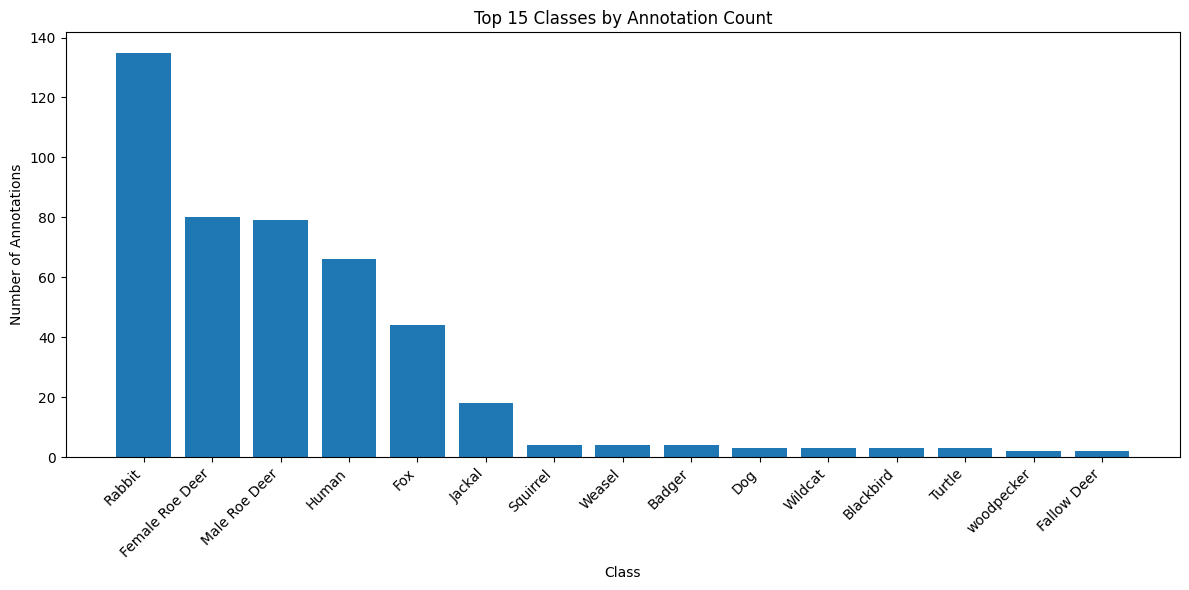


Classes needing augmentation (target count: 10):


,Class ID,Class Name,Current Count,Target Count,Augmentation Factor,Additional Samples Needed,Taxonomic Group
0,0,Red Deer,1,10,10.000000,9,Deer
8,24,Nightingale,1,10,10.000000,9,Birds
10,29,woodpecker,2,10,5.000000,8,Birds
1,3,Fallow Deer,2,10,5.000000,8,Deer
7,23,Blackbird,3,10,3.333333,7,Birds
9,28,Dog,3,10,3.333333,7,Other
6,22,Turtle,3,10,3.333333,7,Other
4,16,Wildcat,3,10,3.333333,7,Carnivores
5,19,Squirrel,4,10,2.500000,6,Small_Mammals
3,11,Weasel,4,10,2.500000,6,Carnivores


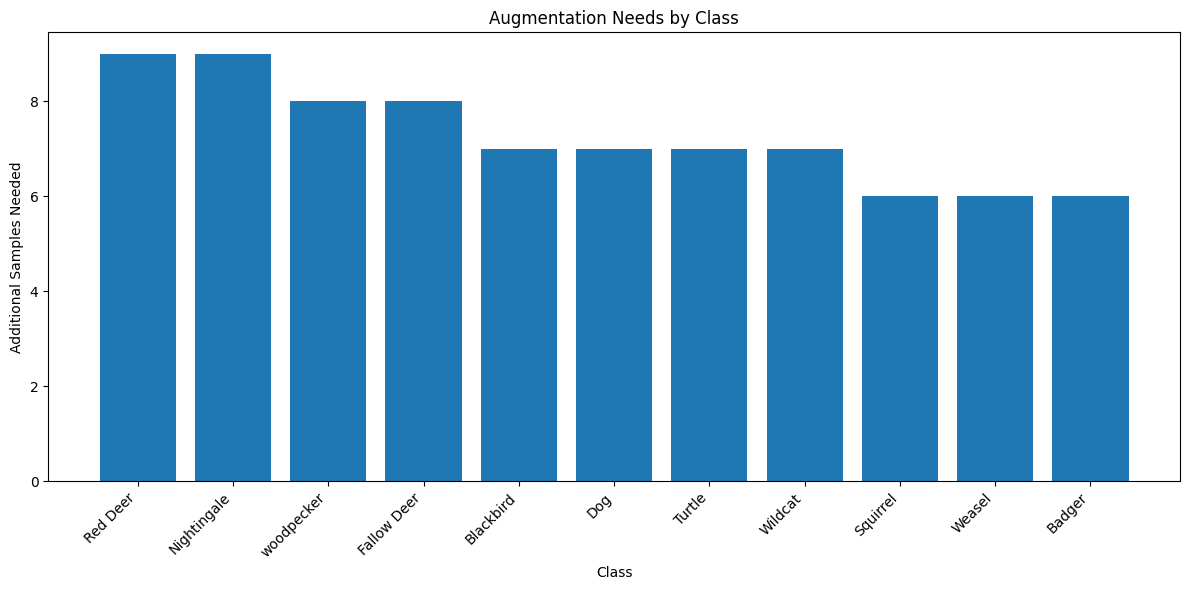

In [5]:
# Cell 5: Data Preparation - Class Balance Analysis
# Analyze class balance and identify needs for augmentation

# Make sure we have the class information from previous cells
if 'class_names' not in locals() or not class_names:
    print("⚠️ Class names not available. Cannot perform balance analysis.")
else:
    # Create inverse mapping from class_id to group
    class_to_group = {}
    for group_name, class_ids in taxonomic_groups.items():
        for class_id in class_ids:
            class_to_group[class_id] = group_name
    
    # Ensure we have class count data
    if 'class_counts' not in locals() or not class_counts:
        print("⚠️ Class count data not available. Cannot perform balance analysis.")
    else:
        # Create a DataFrame for better analysis
        class_df = []
        for class_id in range(len(class_names)):
            train_count = class_counts[class_id]['train']
            val_count = class_counts[class_id]['val']
            total_count = train_count + val_count
            
            # Find taxonomic group
            group = class_to_group.get(class_id, "Unknown")
            
            if total_count > 0:
                train_percent = (train_count / total_count) * 100 if total_count > 0 else 0
                val_percent = (val_count / total_count) * 100 if total_count > 0 else 0
                
                class_df.append({
                    'Class ID': class_id,
                    'Class Name': class_names[class_id],
                    'Train Count': train_count,
                    'Val Count': val_count,
                    'Total': total_count,
                    'Train %': train_percent,
                    'Val %': val_percent,
                    'Taxonomic Group': group
                })
        
        # Convert to DataFrame
        if class_df:
            class_df = pd.DataFrame(class_df)
            
            # Calculate class balance metrics
            total_annotations_sum = class_df['Total'].sum()
            
            if total_annotations_sum > 0:
                proportions = class_df['Total'] / total_annotations_sum
                entropy = -sum(p * np.log2(p) if p > 0 else 0 for p in proportions)
                max_entropy = np.log2(len(class_df)) if len(class_df) > 0 else 0
                balance_ratio = entropy / max_entropy if max_entropy > 0 else 0
                
                print(f"Class balance metrics (higher is better):")
                print(f"Entropy: {entropy:.2f} / {max_entropy:.2f}")
                print(f"Balance ratio: {balance_ratio:.2f} (1.0 = perfectly balanced)")
                
                # Class imbalance visualization
                plt.figure(figsize=(12, 6))
                
                # Sort by count for better visualization
                class_df_sorted = class_df.sort_values('Total', ascending=False)
                
                # Plot class counts
                plt.bar(class_df_sorted['Class Name'].head(15), class_df_sorted['Total'].head(15))
                plt.xlabel('Class')
                plt.ylabel('Number of Annotations')
                plt.title('Top 15 Classes by Annotation Count')
                plt.xticks(rotation=45, ha='right')
                plt.tight_layout()
                plt.show()
                
                # Calculate class imbalance from ideal distribution
                ideal_proportion = 1 / len(class_df) if len(class_df) > 0 else 0
                class_df['Proportion'] = class_df['Total'] / total_annotations_sum
                class_df['Deviation'] = abs(class_df['Proportion'] - ideal_proportion)
                
                # Identify classes needing augmentation
                # Target count per class (using median as base)
                median_count = class_df['Total'].median()
                min_target = 10  # Minimum target for very rare classes
                target_count = max(min_target, median_count)
                
                augmentation_needs = []
                
                for _, row in class_df.iterrows():
                    if row['Total'] < target_count:
                        augmentation_needs.append({
                            'Class ID': row['Class ID'],
                            'Class Name': row['Class Name'],
                            'Current Count': row['Total'],
                            'Target Count': target_count,
                            'Augmentation Factor': target_count / row['Total'] if row['Total'] > 0 else 0,
                            'Additional Samples Needed': target_count - row['Total'],
                            'Taxonomic Group': row['Taxonomic Group']
                        })
                
                if augmentation_needs:
                    aug_df = pd.DataFrame(augmentation_needs)
                    aug_df = aug_df.sort_values('Current Count')
                    
                    print(f"\nClasses needing augmentation (target count: {target_count}):")
                    display(aug_df)
                    
                    # Visualization of augmentation needs
                    plt.figure(figsize=(12, 6))
                    plt.bar(aug_df['Class Name'], aug_df['Additional Samples Needed'])
                    plt.xlabel('Class')
                    plt.ylabel('Additional Samples Needed')
                    plt.title('Augmentation Needs by Class')
                    plt.xticks(rotation=45, ha='right')
                    plt.tight_layout()
                    plt.show()
                else:
                    print("\nNo classes need augmentation based on current balance criteria.")
            else:
                print("No annotations found. Cannot perform balance analysis.")
        else:
            print("No class data available for balance analysis.")

In [6]:
# Cell 6: Data Preparation - Train/Val/Test Splitting
# Define functions for balanced dataset splitting

def create_dataset_splits(image_dir, annotation_dir=None, train_pct=0.7, val_pct=0.2, test_pct=0.1, 
                          stratify=True, seed=42):
    """
    Create balanced train/val/test splits from image data.
    
    Parameters:
        image_dir: Directory with images
        annotation_dir: Directory with annotations (optional)
        train_pct, val_pct, test_pct: Split percentages
        stratify: Whether to stratify by class
        seed: Random seed for reproducibility
    
    Returns:
        splits: Dictionary with file lists for train, val, test
    """
    import random
    random.seed(seed)
    
    # Verify split percentages
    if abs(train_pct + val_pct + test_pct - 1.0) > 0.001:
        print(f"Warning: Split percentages ({train_pct}, {val_pct}, {test_pct}) don't sum to 1. Normalizing.")
        total = train_pct + val_pct + test_pct
        train_pct, val_pct, test_pct = train_pct/total, val_pct/total, test_pct/total
    
    # Check if the directory exists
    if not os.path.exists(image_dir):
        print(f"Error: Image directory doesn't exist: {image_dir}")
        return None
    
    # Get all image files
    image_files = []
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
                image_files.append(os.path.join(root, file))
    
    # Check if we found any images
    if not image_files:
        print(f"Error: No images found in {image_dir}")
        return None
    
    print(f"Found {len(image_files)} images for splitting")
    
    # Shuffle the files
    random.shuffle(image_files)
    
    # Calculate split indices
    train_idx = int(len(image_files) * train_pct)
    val_idx = train_idx + int(len(image_files) * val_pct)
    
    # Split the files
    train_files = image_files[:train_idx]
    val_files = image_files[train_idx:val_idx]
    test_files = image_files[val_idx:]
    
    print(f"Split: {len(train_files)} train, {len(val_files)} validation, {len(test_files)} test")
    
    # Create the splits structure
    splits = {
        'train': {'images': train_files, 'labels': []},
        'val': {'images': val_files, 'labels': []},
        'test': {'images': test_files, 'labels': []}
    }
    
    # If annotations directory is provided, match annotations to images
    if annotation_dir and os.path.exists(annotation_dir):
        # To be implemented for your specific annotation format
        print(f"Note: Annotation matching not implemented for this example")
    
    return splits

# Example: How to use the function with your paths
print("Dataset Splitting Function Defined")
print("This function can be used to create train/val/test splits for new datasets")
print("For the existing YOLO dataset, the splits are already defined")

# Example of how you would use this function (not executed)
example_code = """
# Example usage:
raw_images_dir = paths['raw_data']
if os.path.exists(raw_images_dir):
    splits = create_dataset_splits(
        image_dir=raw_images_dir,
        train_pct=0.7, 
        val_pct=0.2, 
        test_pct=0.1
    )
    
    # Now 'splits' contains the file lists for train/val/test
"""

print("\nExample code for dataset splitting:")
print(example_code)

# Display statistics for the current YOLO dataset splits
if 'yolo_dataset_path' in locals() and os.path.exists(yolo_dataset_path):
    train_images_dir = os.path.join(yolo_dataset_path, 'images/train')
    val_images_dir = os.path.join(yolo_dataset_path, 'images/val')
    
    train_images = os.listdir(train_images_dir) if os.path.exists(train_images_dir) else []
    val_images = os.listdir(val_images_dir) if os.path.exists(val_images_dir) else []
    
    print("\nCurrent YOLO dataset split:")
    print(f"- Training images: {len(train_images)}")
    print(f"- Validation images: {len(val_images)}")
    print(f"- Total images: {len(train_images) + len(val_images)}")
    
    # Calculate split ratio
    total = len(train_images) + len(val_images)
    if total > 0:
        train_ratio = len(train_images) / total
        val_ratio = len(val_images) / total
        print(f"- Training ratio: {train_ratio:.2f}")
        print(f"- Validation ratio: {val_ratio:.2f}")

Dataset Splitting Function Defined
This function can be used to create train/val/test splits for new datasets
For the existing YOLO dataset, the splits are already defined

Example code for dataset splitting:

# Example usage:
raw_images_dir = paths['raw_data']
if os.path.exists(raw_images_dir):
    splits = create_dataset_splits(
        image_dir=raw_images_dir,
        train_pct=0.7, 
        val_pct=0.2, 
        test_pct=0.1
    )

    # Now 'splits' contains the file lists for train/val/test


Current YOLO dataset split:
- Training images: 706
- Validation images: 175
- Total images: 881
- Training ratio: 0.80
- Validation ratio: 0.20


✅ albumentations library is available for advanced augmentation


/tmp/ipykernel_9719/3741489288.py:45: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 50))


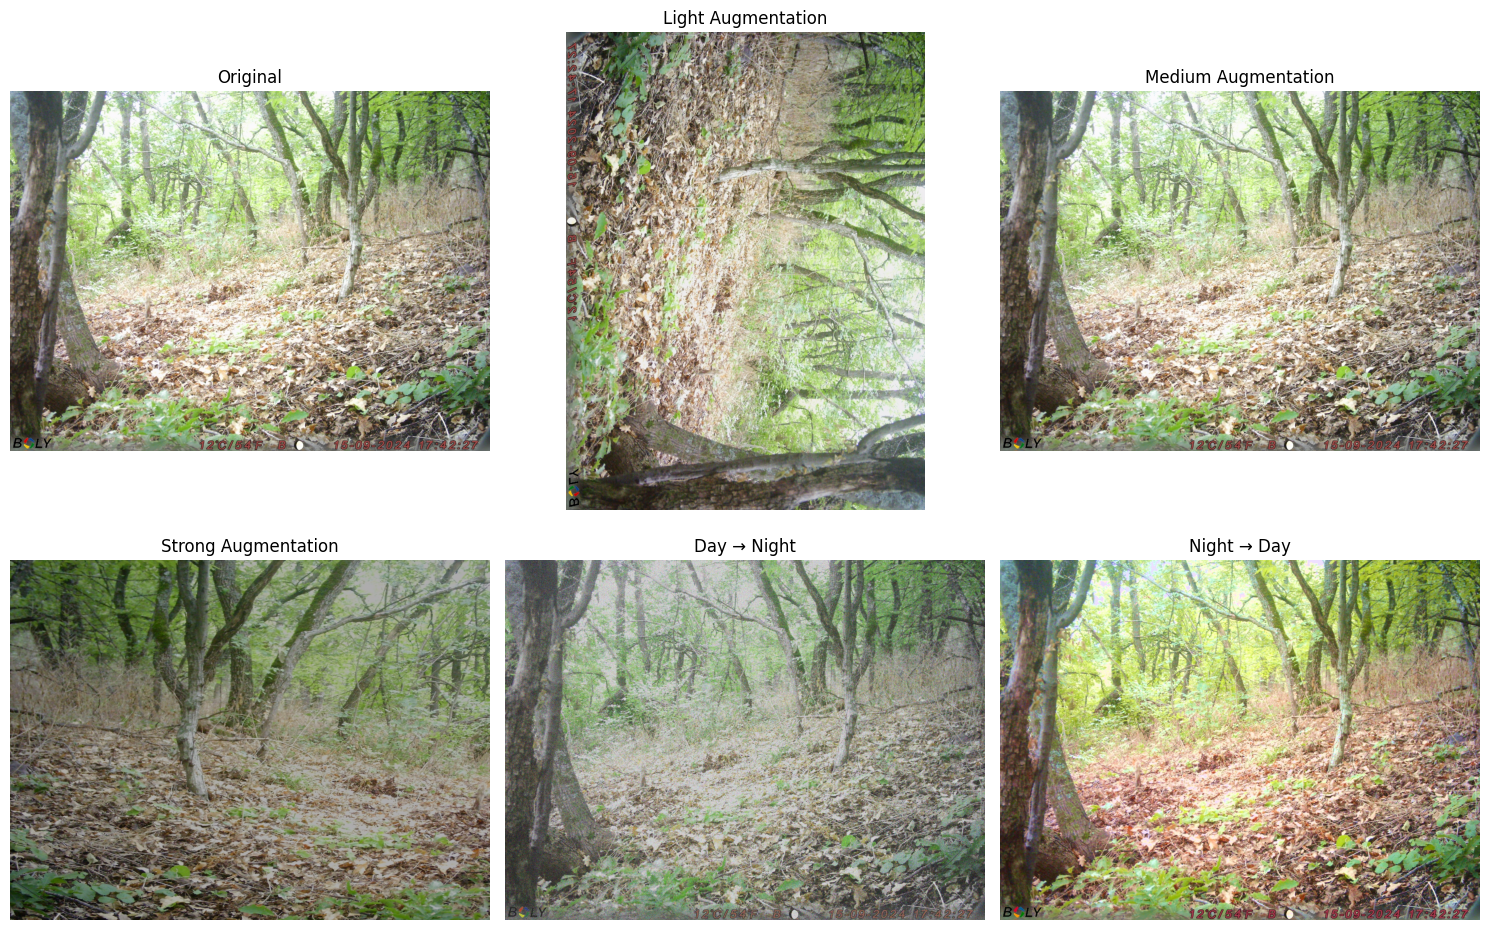

Augmentation strategies ready for use in YOLO export
Different augmentation strengths will be applied based on class balance.


In [9]:
# Cell 7: Augmentation Strategies
# Define augmentation strategies for different classes

# Check if albumentations is available
try:
    import albumentations as A
    AUGMENTATION_AVAILABLE = True
    print("✅ albumentations library is available for advanced augmentation")
except ImportError:
    AUGMENTATION_AVAILABLE = False
    print("⚠️ albumentations not installed. Basic augmentation will be used.")
    print("   Install with: pip install albumentations")

# If albumentations is available, define augmentation strategies
if AUGMENTATION_AVAILABLE:
    # Define different augmentation levels
    light_aug = A.Compose([
        A.RandomRotate90(),
        A.HorizontalFlip(),  # Changed from A.Flip()
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2)
    ])
    
    medium_aug = A.Compose([
        A.RandomRotate90(),
        A.HorizontalFlip(),  # Changed from A.Flip()
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=25, val_shift_limit=15),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15)
    ])
    
    strong_aug = A.Compose([
        A.RandomRotate90(),
        A.HorizontalFlip(),  # Changed from A.Flip()
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20),
        A.GaussNoise(),
        A.Perspective(),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30)
    ])
    
    # Wildlife-specific augmentations
    day_to_night = A.Compose([
        A.RandomBrightnessContrast(brightness_limit=(-0.3, -0.1), contrast_limit=(0.1, 0.3)),
        A.HueSaturationValue(hue_shift_limit=(-10, 10), sat_shift_limit=(-30, -10), val_shift_limit=(-20, -5)),
        A.GaussNoise(var_limit=(10, 50))
    ])
    
    night_to_day = A.Compose([
        A.RandomBrightnessContrast(brightness_limit=(0.1, 0.3), contrast_limit=(-0.1, 0.1)),
        A.HueSaturationValue(hue_shift_limit=(-10, 10), sat_shift_limit=(10, 30), val_shift_limit=(5, 20))
    ])
    
    # Demo augmentation effects on a sample image
    raw_data_path = paths['raw_data']
    if os.path.exists(raw_data_path):
        # Find a sample image
        sample_images = []
        for root, _, files in os.walk(raw_data_path):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    sample_images.append(os.path.join(root, file))
            if sample_images:
                break
        
        if sample_images:
            sample_img_path = sample_images[0]
            try:
                img = cv2.imread(sample_img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    
                    # Apply augmentations
                    light_aug_img = light_aug(image=img)['image']
                    medium_aug_img = medium_aug(image=img)['image']
                    strong_aug_img = strong_aug(image=img)['image']
                    day_to_night_img = day_to_night(image=img)['image']
                    night_to_day_img = night_to_day(image=img)['image']
                    
                    # Display results
                    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
                    axs[0, 0].imshow(img)
                    axs[0, 0].set_title('Original')
                    axs[0, 1].imshow(light_aug_img)
                    axs[0, 1].set_title('Light Augmentation')
                    axs[0, 2].imshow(medium_aug_img)
                    axs[0, 2].set_title('Medium Augmentation')
                    axs[1, 0].imshow(strong_aug_img)
                    axs[1, 0].set_title('Strong Augmentation')
                    axs[1, 1].imshow(day_to_night_img)
                    axs[1, 1].set_title('Day → Night')
                    axs[1, 2].imshow(night_to_day_img)
                    axs[1, 2].set_title('Night → Day')
                    
                    for ax in axs.flat:
                        ax.axis('off')
                    
                    plt.tight_layout()
                    plt.show()
                    
                    print("Augmentation strategies ready for use in YOLO export")
                    print("Different augmentation strengths will be applied based on class balance.")
                else:
                    print(f"Error: Could not read sample image {sample_img_path}")
            except Exception as e:
                print(f"Error demonstrating augmentations: {e}")
        else:
            print("No sample images found for augmentation preview.")
    else:
        print(f"Raw data directory not found: {raw_data_path}")
        print("Augmentation preview not available.")
else:
    # Define YOLO built-in augmentation parameters if albumentations not available
    print("\nYOLO built-in augmentation parameters:")
    print("- hsv_h: 0.015  # HSV Hue augmentation")
    print("- hsv_s: 0.7    # HSV Saturation augmentation (higher for wildlife)")
    print("- hsv_v: 0.4    # HSV Value augmentation (stronger for varying lighting)")
    print("- degrees: 10.0 # Rotation augmentation")
    print("- translate: 0.2  # Translation augmentation")
    print("- scale: 0.6    # Scale augmentation (stronger for wildlife detection)")
    print("- fliplr: 0.5   # Horizontal flip probability")
    print("- mosaic: 1.0   # Mosaic augmentation (keep at max)")
    print("- mixup: 0.1    # Mixup augmentation (moderate)")

In [10]:
# Cell 8: YOLO Export - Preparation
# Prepare for YOLO export by setting up directories and configuration

def prepare_yolo_export(export_path, class_names, taxonomic_groups=None):
    """
    Prepare YOLO export directories and configuration files
    
    Parameters:
        export_path: Base path for export
        class_names: List of class names
        taxonomic_groups: Dictionary of taxonomic groups (optional)
        
    Returns:
        export_paths: Dictionary with export paths
    """
    # Create main directories
    for split in ['train', 'val']:
        os.makedirs(os.path.join(export_path, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(export_path, 'labels', split), exist_ok=True)
    
    # Create classes.txt
    with open(os.path.join(export_path, 'classes.txt'), 'w') as f:
        for class_name in class_names:
            f.write(f"{class_name}\n")
    
    # Create data.yaml
    data_yaml = {
        'path': export_path,
        'train': 'images/train',
        'val': 'images/val',
        'nc': len(class_names),
        'names': class_names
    }
    
    with open(os.path.join(export_path, 'data.yaml'), 'w') as f:
        yaml.dump(data_yaml, f, sort_keys=False)
    
    # Save taxonomic groups if provided
    if taxonomic_groups:
        taxonomic_yaml = {
            'groups': {
                group_name: [class_names[idx] for idx in class_ids if idx < len(class_names)]
                for group_name, class_ids in taxonomic_groups.items()
            }
        }
        
        with open(os.path.join(export_path, 'taxonomic_groups.yaml'), 'w') as f:
            yaml.dump(taxonomic_yaml, f, sort_keys=False)
    
    print(f"YOLO export directories and configurations prepared at: {export_path}")
    
    # Return paths for reference
    export_paths = {
        'base': export_path,
        'train_images': os.path.join(export_path, 'images', 'train'),
        'train_labels': os.path.join(export_path, 'labels', 'train'),
        'val_images': os.path.join(export_path, 'images', 'val'),
        'val_labels': os.path.join(export_path, 'labels', 'val'),
        'classes_txt': os.path.join(export_path, 'classes.txt'),
        'data_yaml': os.path.join(export_path, 'data.yaml')
    }
    
    return export_paths

# Setup export paths using the paths defined in Cell 2
if 'class_names' in locals() and class_names:
    # Standard dataset export path using the exact paths from your notebook
    standard_export_path = paths['yolo_export']
    print(f"Setting up standard YOLO export at: {standard_export_path}")
    standard_export_paths = prepare_yolo_export(standard_export_path, class_names, taxonomic_groups)
    
    # Hierarchical dataset export path (if taxonomic groups defined)
    if 'taxonomic_groups' in locals() and taxonomic_groups:
        hierarchical_export_path = paths['yolo_hierarchical_export']
        print(f"Setting up hierarchical YOLO export at: {hierarchical_export_path}")
        
        # Create hierarchical class names (taxonomic groups as classes)
        hierarchical_class_names = list(taxonomic_groups.keys())
        
        hierarchical_export_paths = prepare_yolo_export(
            hierarchical_export_path, 
            hierarchical_class_names
        )
        
        # Create mapping from original class IDs to hierarchical class IDs
        hierarchical_mapping = {}
        for group_idx, (group_name, class_ids) in enumerate(taxonomic_groups.items()):
            for class_id in class_ids:
                if class_id < len(class_names):
                    hierarchical_mapping[class_id] = group_idx
        
        # Save mapping for use during export
        with open(os.path.join(hierarchical_export_path, 'hierarchical_mapping.json'), 'w') as f:
            json.dump(hierarchical_mapping, f, indent=2)
        
        print(f"Hierarchical mapping saved with {len(hierarchical_mapping)} classes mapped to {len(hierarchical_class_names)} groups")
else:
    print("Error: Class names not available. Cannot prepare YOLO export.")
    print("Make sure the YOLO dataset analysis in Cell 4 completed successfully.")

Setting up standard YOLO export at: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem/data/export/yolo_export_test_01_20250510_0038
YOLO export directories and configurations prepared at: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem/data/export/yolo_export_test_01_20250510_0038
Setting up hierarchical YOLO export at: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem/data/export/yolo_hierarchical_test_01_20250510_0038
YOLO export directories and configurations prepared at: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem/data/export/yolo_hierarchical_test_01_20250510_0038
Hierarchical mapping saved with 30 classes mapped to 5 groups


In [11]:
# Cell 9: YOLO Export - Execute
# Execute YOLO export for both standard and hierarchical datasets

def copy_yolo_dataset(source_dataset, target_dataset, apply_augmentation=False, augment_classes=None):
    """
    Copy a YOLO dataset from source to target with optional augmentation
    
    Parameters:
        source_dataset: Path to source YOLO dataset
        target_dataset: Path to target YOLO dataset
        apply_augmentation: Whether to apply augmentation
        augment_classes: Dict of class IDs to augmentation counts (optional)
    
    Returns:
        bool: Success status
    """
    # Check paths
    if not os.path.exists(source_dataset):
        print(f"Error: Source dataset not found: {source_dataset}")
        return False
    
    # Check target directories
    target_train_images = os.path.join(target_dataset, 'images', 'train')
    target_train_labels = os.path.join(target_dataset, 'labels', 'train')
    target_val_images = os.path.join(target_dataset, 'images', 'val')
    target_val_labels = os.path.join(target_dataset, 'labels', 'val')
    
    for path in [target_train_images, target_train_labels, target_val_images, target_val_labels]:
        os.makedirs(path, exist_ok=True)
    
    # Copy files
    copied_counts = {'train_images': 0, 'train_labels': 0, 'val_images': 0, 'val_labels': 0}
    
    # Copy training images and labels
    source_train_images = os.path.join(source_dataset, 'images', 'train')
    source_train_labels = os.path.join(source_dataset, 'labels', 'train')
    
    if os.path.exists(source_train_images) and os.path.exists(source_train_labels):
        # Copy images
        for img_file in os.listdir(source_train_images):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                shutil.copy2(
                    os.path.join(source_train_images, img_file),
                    os.path.join(target_train_images, img_file)
                )
                copied_counts['train_images'] += 1
        
        # Copy labels
        for label_file in os.listdir(source_train_labels):
            if label_file.endswith('.txt'):
                shutil.copy2(
                    os.path.join(source_train_labels, label_file),
                    os.path.join(target_train_labels, label_file)
                )
                copied_counts['train_labels'] += 1
    
    # Copy validation images and labels
    source_val_images = os.path.join(source_dataset, 'images', 'val')
    source_val_labels = os.path.join(source_dataset, 'labels', 'val')
    
    if os.path.exists(source_val_images) and os.path.exists(source_val_labels):
        # Copy images
        for img_file in os.listdir(source_val_images):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                shutil.copy2(
                    os.path.join(source_val_images, img_file),
                    os.path.join(target_val_images, img_file)
                )
                copied_counts['val_images'] += 1
        
        # Copy labels
        for label_file in os.listdir(source_val_labels):
            if label_file.endswith('.txt'):
                shutil.copy2(
                    os.path.join(source_val_labels, label_file),
                    os.path.join(target_val_labels, label_file)
                )
                copied_counts['val_labels'] += 1
    
    print(f"Copied files:")
    print(f"- Training images: {copied_counts['train_images']}")
    print(f"- Training labels: {copied_counts['train_labels']}")
    print(f"- Validation images: {copied_counts['val_images']}")
    print(f"- Validation labels: {copied_counts['val_labels']}")
    
    # Apply augmentation if requested (placeholder)
    if apply_augmentation and augment_classes:
        print("\nAugmentation would be applied here for underrepresented classes")
        # In a real implementation, this would apply the augmentation strategies
        # from Cell 7 to generate additional samples for the specified classes
    
    return True

def create_hierarchical_labels(source_dataset, target_dataset, hierarchical_mapping):
    """
    Create hierarchical labels by mapping species to taxonomic groups
    
    Parameters:
        source_dataset: Path to source YOLO dataset
        target_dataset: Path to target YOLO dataset
        hierarchical_mapping: Mapping from species to taxonomic group
        
    Returns:
        bool: Success status
    """
    # Check paths
    if not os.path.exists(source_dataset):
        print(f"Error: Source dataset not found: {source_dataset}")
        return False
    
    # Get label directories
    source_train_labels = os.path.join(source_dataset, 'labels', 'train')
    source_val_labels = os.path.join(source_dataset, 'labels', 'val')
    target_train_labels = os.path.join(target_dataset, 'labels', 'train')
    target_val_labels = os.path.join(target_dataset, 'labels', 'val')
    
    if not os.path.exists(source_train_labels) or not os.path.exists(source_val_labels):
        print(f"Error: Source label directories not found")
        return False
    
    # Process training labels
    if os.path.exists(source_train_labels):
        for label_file in os.listdir(source_train_labels):
            if label_file.endswith('.txt'):
                source_path = os.path.join(source_train_labels, label_file)
                target_path = os.path.join(target_train_labels, label_file)
                
                # Read original labels
                with open(source_path, 'r') as f:
                    lines = f.readlines()
                
                # Map class IDs to hierarchical IDs
                new_lines = []
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        if class_id in hierarchical_mapping:
                            # Replace class ID with taxonomic group ID
                            new_class_id = hierarchical_mapping[class_id]
                            parts[0] = str(new_class_id)
                            new_lines.append(' '.join(parts) + '\n')
                
                # Write new labels
                with open(target_path, 'w') as f:
                    f.writelines(new_lines)
    
    # Process validation labels
    if os.path.exists(source_val_labels):
        for label_file in os.listdir(source_val_labels):
            if label_file.endswith('.txt'):
                source_path = os.path.join(source_val_labels, label_file)
                target_path = os.path.join(target_val_labels, label_file)
                
                # Read original labels
                with open(source_path, 'r') as f:
                    lines = f.readlines()
                
                # Map class IDs to hierarchical IDs
                new_lines = []
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        if class_id in hierarchical_mapping:
                            # Replace class ID with taxonomic group ID
                            new_class_id = hierarchical_mapping[class_id]
                            parts[0] = str(new_class_id)
                            new_lines.append(' '.join(parts) + '\n')
                
                # Write new labels
                with open(target_path, 'w') as f:
                    f.writelines(new_lines)
    
    return True

# Use the paths from your notebook
if 'yolo_dataset_path' in locals() and os.path.exists(yolo_dataset_path):
    print(f"Using YOLO dataset: {yolo_dataset_path}")
    
    # Determine augmentation needs if available
    augment_classes = None
    if 'aug_df' in locals() and 'aug_df' in globals():
        augment_classes = {
            row['Class ID']: row['Additional Samples Needed']
            for _, row in aug_df.iterrows()
        }
        print(f"Augmentation will be applied to {len(augment_classes)} underrepresented classes")
    
    # Execute standard export
    if 'standard_export_paths' in locals():
        print("\nExecuting standard YOLO export...")
        standard_export_success = copy_yolo_dataset(
            yolo_dataset_path,
            standard_export_paths['base'],
            apply_augmentation=(augment_classes is not None),
            augment_classes=augment_classes
        )
        
        if standard_export_success:
            print(f"Standard YOLO dataset export completed")
        else:
            print(f"Standard YOLO dataset export failed")
    
    # Execute hierarchical export
    if 'hierarchical_export_paths' in locals() and 'hierarchical_mapping' in locals():
        print("\nExecuting hierarchical YOLO export...")
        # First copy images
        hierarchical_copy_success = copy_yolo_dataset(
            yolo_dataset_path,
            hierarchical_export_paths['base'],
            apply_augmentation=False  # No augmentation for hierarchical export
        )
        
        # Then create hierarchical labels
        if hierarchical_copy_success:
            hierarchical_labels_success = create_hierarchical_labels(
                yolo_dataset_path,
                hierarchical_export_paths['base'],
                hierarchical_mapping
            )
            
            if hierarchical_labels_success:
                print(f"Hierarchical YOLO dataset export completed")
            else:
                print(f"Hierarchical label conversion failed")
        else:
            print(f"Hierarchical YOLO dataset export failed")
else:
    print("Error: No YOLO dataset available. Export cannot proceed.")
    print("Make sure the YOLO dataset analysis in Cell 4 completed successfully.")

Using YOLO dataset: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem/data/export/yolo_default_20250429_085945
Augmentation will be applied to 11 underrepresented classes

Executing standard YOLO export...
Copied files:
- Training images: 356
- Training labels: 356
- Validation images: 89
- Validation labels: 89

Augmentation would be applied here for underrepresented classes
Standard YOLO dataset export completed

Executing hierarchical YOLO export...
Copied files:
- Training images: 356
- Training labels: 356
- Validation images: 89
- Validation labels: 89
Hierarchical YOLO dataset export completed


In [12]:
# Cell 10: Dataset Summary and Export Report
# Generate summary report of the dataset and export

def generate_export_report(export_path, class_counts=None, augmentation_info=None):
    """Generate a summary report of the dataset export"""
    if not os.path.exists(export_path):
        print(f"Error: Export path does not exist: {export_path}")
        return None
    
    report_data = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "export_path": export_path,
        "classes": {
            "path": os.path.join(export_path, 'classes.txt'),
            "count": 0
        },
        "data_yaml": {
            "path": os.path.join(export_path, 'data.yaml')
        },
        "files": {
            "train_images": 0,
            "train_labels": 0,
            "val_images": 0,
            "val_labels": 0
        }
    }
    
    # Count classes
    classes_txt = os.path.join(export_path, 'classes.txt')
    if os.path.exists(classes_txt):
        with open(classes_txt, 'r') as f:
            classes = [line.strip() for line in f.readlines()]
            report_data["classes"]["count"] = len(classes)
            report_data["classes"]["names"] = classes
    
    # Count files
    train_images_dir = os.path.join(export_path, 'images', 'train')
    train_labels_dir = os.path.join(export_path, 'labels', 'train')
    val_images_dir = os.path.join(export_path, 'images', 'val')
    val_labels_dir = os.path.join(export_path, 'labels', 'val')
    
    if os.path.exists(train_images_dir):
        train_images = [f for f in os.listdir(train_images_dir) if os.path.isfile(os.path.join(train_images_dir, f))]
        report_data["files"]["train_images"] = len(train_images)
    
    if os.path.exists(train_labels_dir):
        train_labels = [f for f in os.listdir(train_labels_dir) if os.path.isfile(os.path.join(train_labels_dir, f))]
        report_data["files"]["train_labels"] = len(train_labels)
    
    if os.path.exists(val_images_dir):
        val_images = [f for f in os.listdir(val_images_dir) if os.path.isfile(os.path.join(val_images_dir, f))]
        report_data["files"]["val_images"] = len(val_images)
    
    if os.path.exists(val_labels_dir):
        val_labels = [f for f in os.listdir(val_labels_dir) if os.path.isfile(os.path.join(val_labels_dir, f))]
        report_data["files"]["val_labels"] = len(val_labels)
    
    # Add class counts if available
    if class_counts is not None:
        report_data["class_counts"] = class_counts
    
    # Add augmentation info if available
    if augmentation_info is not None:
        report_data["augmentation"] = augmentation_info
    
    # Generate markdown report
    report_md = f"# YOLO Dataset Export Report\n\n"
    report_md += f"## Export Details\n\n"
    report_md += f"- **Timestamp:** {report_data['timestamp']}\n"
    report_md += f"- **Export Path:** {report_data['export_path']}\n"
    report_md += f"- **Classes:** {report_data['classes']['count']}\n"
    report_md += f"- **Data YAML:** {report_data['data_yaml']['path']}\n\n"
    
    report_md += f"## File Counts\n\n"
    report_md += f"- **Train Images:** {report_data['files']['train_images']}\n"
    report_md += f"- **Train Labels:** {report_data['files']['train_labels']}\n"
    report_md += f"- **Validation Images:** {report_data['files']['val_images']}\n"
    report_md += f"- **Validation Labels:** {report_data['files']['val_labels']}\n\n"
    
    if "class_counts" in report_data:
        report_md += f"## Class Counts\n\n"
        report_md += f"Class | Train | Validation | Total\n"
        report_md += f"--- | --- | --- | ---\n"
        for class_name, counts in report_data["class_counts"].items():
            report_md += f"{class_name} | {counts['train']} | {counts['val']} | {counts['train'] + counts['val']}\n"
        report_md += "\n"
    
    if "augmentation" in report_data:
        report_md += f"## Augmentation\n\n"
        report_md += f"Class | Original Count | Augmented | Total\n"
        report_md += f"--- | --- | --- | ---\n"
        for class_name, info in report_data["augmentation"].items():
            report_md += f"{class_name} | {info['original']} | {info['augmented']} | {info['total']}\n"
        report_md += "\n"
    
    # Save report
    report_path = os.path.join(export_path, "export_report.md")
    with open(report_path, 'w') as f:
        f.write(report_md)
    
    # Save JSON data
    json_path = os.path.join(export_path, "export_report.json")
    with open(json_path, 'w') as f:
        json.dump(report_data, f, indent=2)
    
    print(f"Export report saved to: {report_path}")
    
    return report_data

# Generate reports for standard and hierarchical exports
for export_path_var, export_desc in [('standard_export_paths', 'Standard'), ('hierarchical_export_paths', 'Hierarchical')]:
    if export_path_var in locals() and locals()[export_path_var]:
        export_paths = locals()[export_path_var]
        
        print(f"\nGenerating report for {export_desc} YOLO Export...")
        
        # Get class counts from the dataset if available
        export_class_counts = {}
        if 'class_counts' in locals() and 'class_names' in locals():
            for class_id, counts in class_counts.items():
                if class_id < len(class_names):
                    export_class_counts[class_names[class_id]] = counts
        
        # Get augmentation info if available
        augmentation_info = None
        if 'aug_df' in locals() and 'aug_df' in globals():
            augmentation_info = {}
            for _, row in aug_df.iterrows():
                augmentation_info[row['Class Name']] = {
                    'original': row['Current Count'],
                    'augmented': row['Additional Samples Needed'],
                    'total': row['Target Count']
                }
        
        # Generate report
        report_data = generate_export_report(
            export_paths['base'],
            export_class_counts,
            augmentation_info
        )

print("\nData preparation and export complete!")
print("The exported datasets are ready for model training.")
print("Please proceed to the model training notebook.")

# Save the class names, taxonomic groups, and paths for use in other notebooks
notebook_data = {
    "class_names": class_names if 'class_names' in locals() else None,
    "taxonomic_groups": taxonomic_groups if 'taxonomic_groups' in locals() else None,
    "standard_export_path": standard_export_paths['base'] if 'standard_export_paths' in locals() else None,
    "hierarchical_export_path": hierarchical_export_paths['base'] if 'hierarchical_export_paths' in locals() else None,
    "yolo_dataset_path": yolo_dataset_path if 'yolo_dataset_path' in locals() else None,
    "timestamp": timestamp
}

# Make sure config directory exists
config_dir = os.path.join(PROJECT_DIR, "config")
os.makedirs(config_dir, exist_ok=True)

notebook_data_path = os.path.join(config_dir, f"notebook_data_{timestamp}.json")
with open(notebook_data_path, 'w') as f:
    json.dump(notebook_data, f, indent=2)

print(f"Notebook data saved to: {notebook_data_path}")


Generating report for Standard YOLO Export...
Export report saved to: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem/data/export/yolo_export_test_01_20250510_0038/export_report.md

Generating report for Hierarchical YOLO Export...
Export report saved to: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem/data/export/yolo_hierarchical_test_01_20250510_0038/export_report.md

Data preparation and export complete!
The exported datasets are ready for model training.
Please proceed to the model training notebook.
Notebook data saved to: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem/config/notebook_data_20250510_0038.json


In [13]:
# Cell 11: Output Tracking for Long-Term Project Management
# This cell creates a detailed record of all files generated by this notebook

# Define the tracking file location
tracking_dir = os.path.join(PROJECT_DIR, "tracking")
os.makedirs(tracking_dir, exist_ok=True)

# Collect all generated files and their purposes
generated_files = {
    "configuration": {
        "data_config": config_path,
        "notebook_data": notebook_data_path
    },
    "standard_dataset": {
        "base_path": standard_export_paths['base'],
        "data_yaml": os.path.join(standard_export_paths['base'], 'data.yaml'),
        "classes_txt": os.path.join(standard_export_paths['base'], 'classes.txt'),
        "report_md": os.path.join(standard_export_paths['base'], 'export_report.md'),
        "report_json": os.path.join(standard_export_paths['base'], 'export_report.json')
    },
    "hierarchical_dataset": {
        "base_path": hierarchical_export_paths['base'],
        "data_yaml": os.path.join(hierarchical_export_paths['base'], 'data.yaml'),
        "classes_txt": os.path.join(hierarchical_export_paths['base'], 'classes.txt'),
        "mapping_json": os.path.join(hierarchical_export_paths['base'], 'hierarchical_mapping.json'), 
        "report_md": os.path.join(hierarchical_export_paths['base'], 'export_report.md'),
        "report_json": os.path.join(hierarchical_export_paths['base'], 'export_report.json')
    }
}

# Create a comprehensive output tracking file
tracking_file = os.path.join(tracking_dir, f"notebook1_outputs_{timestamp}.json")
with open(tracking_file, 'w') as f:
    json.dump({
        "notebook": "01_data_preparation",
        "execution_timestamp": timestamp,
        "description": "Data preparation and YOLO export",
        "generated_files": generated_files,
        "next_steps": {
            "notebook": "02_model_training.ipynb",
            "required_inputs": [notebook_data_path]
        }
    }, f, indent=2)

# Create a simple Markdown summary for human-readable reference
summary_file = os.path.join(tracking_dir, f"notebook1_summary_{timestamp}.md")
with open(summary_file, 'w') as f:
    f.write(f"# Data Preparation Notebook Outputs\n\n")
    f.write(f"**Execution Date:** {datetime.now().strftime('%Y-%m-%d %H:%M')}\n\n")
    
    f.write(f"## Configuration Files\n\n")
    f.write(f"- Data Config: `{config_path}`\n")
    f.write(f"- Notebook Data: `{notebook_data_path}`\n\n")
    
    f.write(f"## Standard YOLO Dataset\n\n")
    f.write(f"- Base Path: `{standard_export_paths['base']}`\n")
    f.write(f"- Classes: {len(class_names)}\n")
    f.write(f"- Training Images: {len(os.listdir(standard_export_paths['train_images']))}\n")
    f.write(f"- Validation Images: {len(os.listdir(standard_export_paths['val_images']))}\n\n")
    
    f.write(f"## Hierarchical YOLO Dataset\n\n")
    f.write(f"- Base Path: `{hierarchical_export_paths['base']}`\n")
    f.write(f"- Groups: {len(list(taxonomic_groups.keys()))}\n")
    f.write(f"- Training Images: {len(os.listdir(hierarchical_export_paths['train_images']))}\n")
    f.write(f"- Validation Images: {len(os.listdir(hierarchical_export_paths['val_images']))}\n\n")
    
    f.write(f"## Next Steps\n\n")
    f.write(f"Proceed to notebook 2 (Model Training) using the notebook data: `{os.path.basename(notebook_data_path)}`")

print(f"\nOutput tracking files created:")
print(f"- JSON tracking: {tracking_file}")
print(f"- Markdown summary: {summary_file}")
print(f"\nThese files document all outputs from this notebook for long-term project organization.")


Output tracking files created:
- JSON tracking: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem/tracking/notebook1_outputs_20250510_0038.json
- Markdown summary: /home/peter/Desktop/TU PHD/WildlifeDetectionSystem/tracking/notebook1_summary_20250510_0038.md

These files document all outputs from this notebook for long-term project organization.
